<a href="https://colab.research.google.com/github/KirtiNayak11/Computer-Vision/blob/main/road_lane_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import cv2
import torch
import copy
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
import torchvision.transforms.functional as F

class FruitsDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [img_id for img_id in self.ids if len(self._load_target(img_id)) > 0]

    def _load_image(self, img_id):
        filename = self.coco.loadImgs(img_id)[0]['file_name']
        image_path = os.path.join(self.root, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, img_id):
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        return self.coco.loadAnns(ann_ids)

    def _ann_to_mask(self, ann, height, width):
        rle = coco_mask.frPyObjects(ann['segmentation'], height, width)
        rle = coco_mask.merge(rle)
        mask = coco_mask.decode(rle)
        if len(mask.shape) == 3:
            mask = np.any(mask, axis=2)
        return mask.astype(np.uint8)

    def __getitem__(self, index):
        img_id = self.ids[index]
        image = self._load_image(img_id)
        target = copy.deepcopy(self._load_target(img_id))
        height, width = image.shape[:2]

        boxes, labels, masks, areas, iscrowd = [], [], [], [], []

        for ann in target:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            masks.append(self._ann_to_mask(ann, height, width))
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(np.stack(masks, axis=0), dtype=torch.uint8)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target_dict = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([img_id]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            image = self.transforms(image)
        else:
            image = torch.tensor(image / 255., dtype=torch.float32).permute(2, 0, 1)

        return image, target_dict

    def __len__(self):
        return len(self.ids)

    def collate_fn(self, batch):
        return tuple(zip(*batch))

In [ ]:
import os

In [ ]:
#load classes
coco = COCO("/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/annotations/instances_train2017.json")
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!


{0: {'id': 0, 'name': 'road-roads', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'divider-line', 'supercategory': 'road-roads'},
 2: {'id': 2, 'name': 'dotted-line', 'supercategory': 'road-roads'},
 3: {'id': 3, 'name': 'double-line', 'supercategory': 'road-roads'},
 4: {'id': 4, 'name': 'random-line', 'supercategory': 'road-roads'},
 5: {'id': 5, 'name': 'road-sign-line', 'supercategory': 'road-roads'},
 6: {'id': 6, 'name': 'solid-line', 'supercategory': 'road-roads'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['road-roads',
 'divider-line',
 'dotted-line',
 'double-line',
 'random-line',
 'road-sign-line',
 'solid-line']

In [ ]:
train_dataset = FruitsDataset(
    root="/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/train2017",
    annotation="/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/annotations/instances_train2017.json"
)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [ ]:
tr_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn)

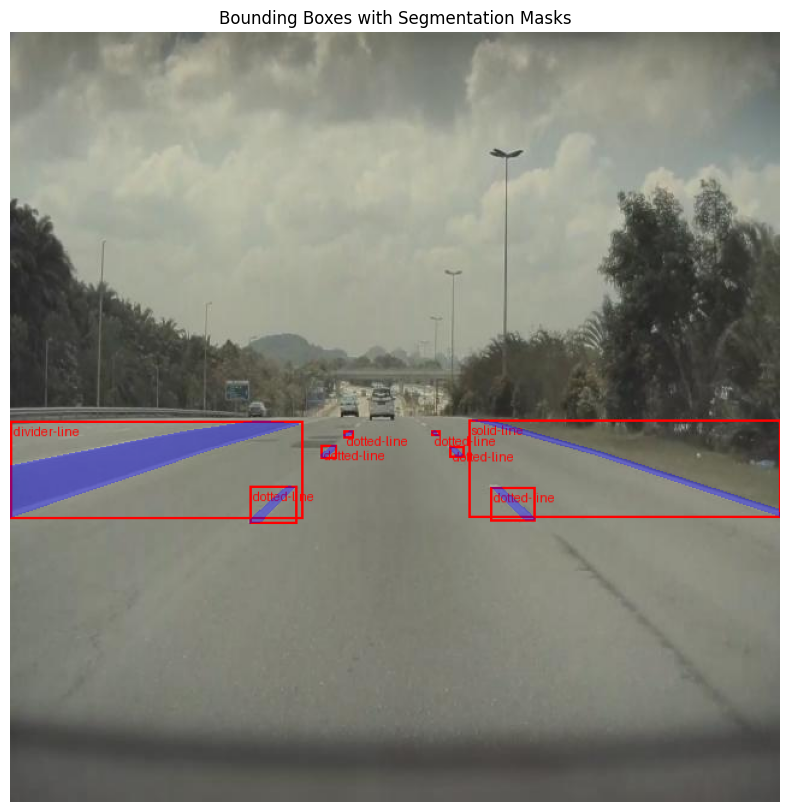

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.functional as F

# Sample
sample = train_dataset[2]
image_tensor = sample[0]  # C, H, W (float in 0-1)
target = sample[1]

# Convert image to uint8
img_int = (image_tensor * 255).to(torch.uint8)

# Create a boolean mask for each instance
masks = target["masks"] > 0  # (N, H, W), type: torch.bool

# Draw bounding boxes
img_with_boxes = draw_bounding_boxes(
    img_int, target['boxes'],
    labels=[classes[i] for i in target['labels']],
    width=2, colors="red"
)

# Draw segmentation masks
img_with_masks = draw_segmentation_masks(
    img_with_boxes, masks=masks, alpha=0.4, colors="blue"
)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(img_with_masks.permute(1, 2, 0))
plt.axis('off')
plt.title("Bounding Boxes with Segmentation Masks")
plt.show()


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model():
    import torchvision

    # Load the Mask R-CNN model with pretrained weights
    model = maskrcnn_resnet50_fpn(pretrained=True)

    # Replace box predictor (for classification and bbox regression)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes+1)

    # Replace mask predictor (for instance segmentation)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, n_classes+1)
    return model


# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 201MB/s] 


{'loss_classifier': tensor(2.6408, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1374, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(2.1948, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(2.2212, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.1840, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
# test the model
imgs, targets = next(iter(tr_dl))
imgs = list(img.to(device) for img in imgs)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model = get_model().to(device)
model(imgs, targets)

{'loss_classifier': tensor(1.8998, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0904, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(1.0156, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(3.7024, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.5188, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
def train_batch(batch, model, optimizer):
    model.train()
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(batch, model):
    model.eval()  # use eval mode for validation
    imgs, targets = batch
    imgs = list(img.to(device) for img in imgs)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    losses = model(imgs, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

# Define model and optimizer
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            weight_decay=5e-4, momentum=0.9)

log = {'train_loss': []}
n_epochs = 5

for e in range(n_epochs):
    epoch_loss = 0
    for i, batch in enumerate(tr_dl):
        loss, losses = train_batch(batch, model, optimizer)
        epoch_loss += loss.item()
        print(f"Epoch {e+1}, Batch {i+1}, Loss: {loss.item():.4f}")
    avg_loss = epoch_loss / len(tr_dl)
    log['train_loss'].append(avg_loss)
    print(f"[Epoch {e+1}] Average Loss: {avg_loss:.4f}")


Epoch 1, Batch 1, Loss: 8.2151
Epoch 1, Batch 2, Loss: 2.6740
Epoch 1, Batch 3, Loss: 1.9857
Epoch 1, Batch 4, Loss: 1.5943
Epoch 1, Batch 5, Loss: 2.4294
Epoch 1, Batch 6, Loss: 2.2003
Epoch 1, Batch 7, Loss: 1.5146
Epoch 1, Batch 8, Loss: 1.3926
Epoch 1, Batch 9, Loss: 1.6979
Epoch 1, Batch 10, Loss: 1.3576
Epoch 1, Batch 11, Loss: 1.9886
Epoch 1, Batch 12, Loss: 1.7320
Epoch 1, Batch 13, Loss: 1.4250
Epoch 1, Batch 14, Loss: 1.2383
Epoch 1, Batch 15, Loss: 1.6926
Epoch 1, Batch 16, Loss: 1.3982
Epoch 1, Batch 17, Loss: 1.3422
Epoch 1, Batch 18, Loss: 1.3984
Epoch 1, Batch 19, Loss: 1.5345
Epoch 1, Batch 20, Loss: 1.6648
Epoch 1, Batch 21, Loss: 1.3079
Epoch 1, Batch 22, Loss: 1.2812
Epoch 1, Batch 23, Loss: 1.4947
Epoch 1, Batch 24, Loss: 1.5371
Epoch 1, Batch 25, Loss: 1.3799
Epoch 1, Batch 26, Loss: 1.5726
Epoch 1, Batch 27, Loss: 1.4272
Epoch 1, Batch 28, Loss: 1.9457
Epoch 1, Batch 29, Loss: 1.3557
Epoch 1, Batch 30, Loss: 0.9825
Epoch 1, Batch 31, Loss: 1.3848
Epoch 1, Batch 32

In [ ]:
val_dataset = FruitsDataset(
    root="/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/val2017",
    annotation="/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/annotations/instances_val2017.json"
)

val_dl = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=val_dataset.collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
root = '/kaggle/input/road-lane-instance-segmentation/road_lane_instance_segmentation/train2017'

# we have four labels
labels = ['__background__', 'divider-line', 'dotted-line', 'double-line', 'random-line', 'road-sign-line', 'solid-line']
label2targets = {l: i for i, l in enumerate(labels)}
targets2label = {i: l for l, i in label2targets.items()}
num_classes = len(labels)

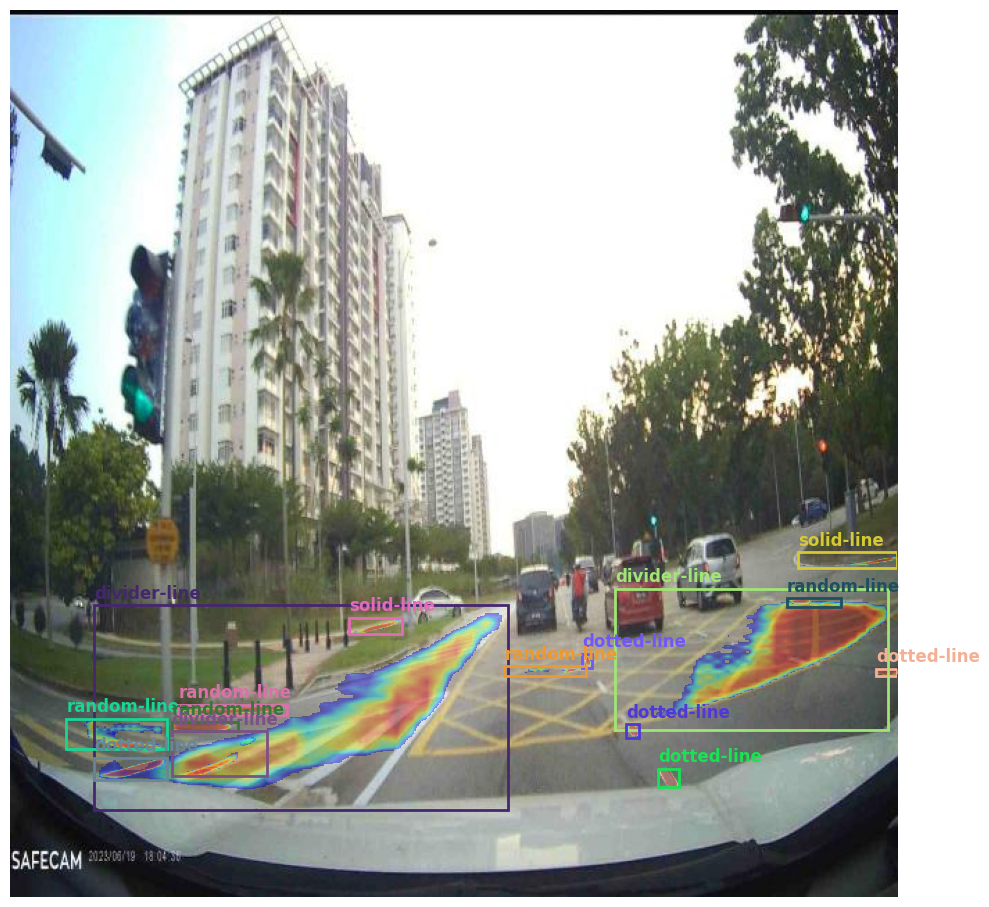

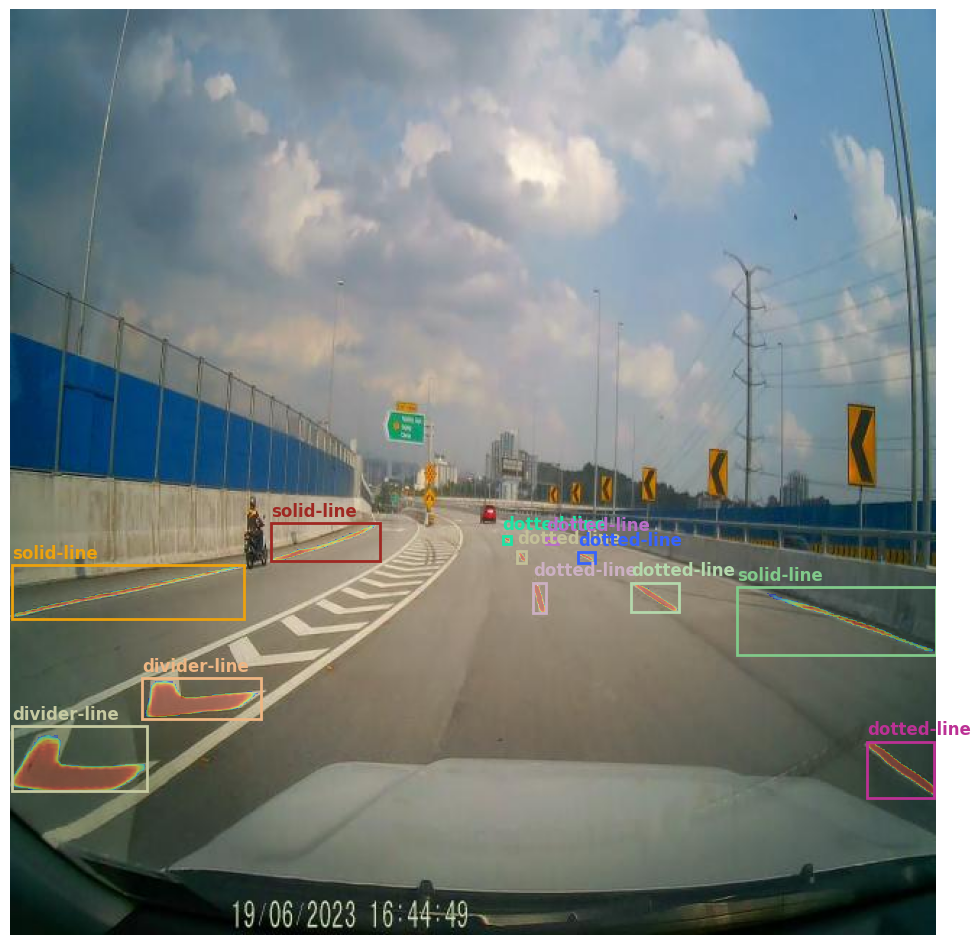

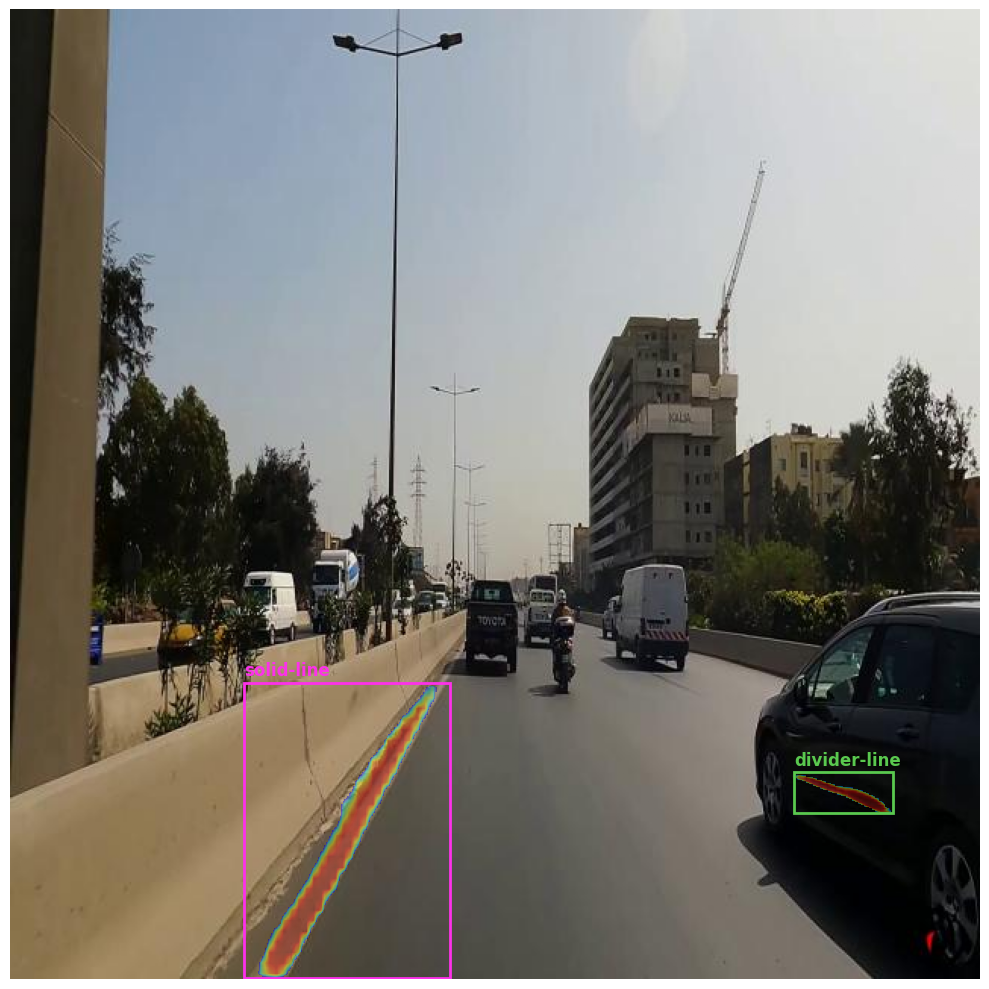

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import nms
import matplotlib.patches as patches
import random

# Safe decode_output with mask handling
def decode_output(output, targets2label):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels_raw = output['labels'].cpu().detach().numpy()
    labels = np.array([targets2label.get(i, f"Class_{i}") for i in labels_raw])
    confs = output['scores'].cpu().detach().numpy()
    masks = output['masks'].cpu().detach().numpy()  # Shape: [N, 1, H, W]

    idxs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), iou_threshold=0.05)

    bbs = bbs[idxs]
    confs = confs[idxs]
    labels = labels[idxs]
    masks = masks[idxs]

    if len(idxs) == 1:
        bbs = np.array([bbs[0]])
        confs = np.array([confs[0]])
        labels = np.array([labels[0]])
        masks = np.array([masks[0]])

    return bbs.tolist(), confs.tolist(), labels.tolist(), masks

# Show function for image, boxes, labels, and masks
def show_instance_segmentation(image, bbs, labels, masks, alpha=0.4):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    for i in range(len(bbs)):
        color = [random.random() for _ in range(3)]
        # Draw bounding box
        box = bbs[i]
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1]-5, labels[i], color=color, fontsize=12, weight='bold')

        # Overlay mask
        mask = masks[i][0]
        ax.imshow(np.ma.masked_where(mask < 0.5, mask), cmap='jet', alpha=alpha)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

import random

# Pick 3 random indices from the validation dataset
rand_indices = random.sample(range(len(val_dl)), 3)

# Run inference on the randomly selected images
for idx in rand_indices:
    image, target = val_dl.dataset[idx]
    image = image.to(device)

    model.eval()
    with torch.no_grad():
        output = model([image])[0]

    # Decode and visualize
    bbs, confs, labels, masks = decode_output(output, targets2label)
    show_instance_segmentation(image.cpu().permute(1, 2, 0), bbs, labels, masks)

In [ ]:
torch.save(model,'/kaggle/working/road-lane-instance-segmentation.pth')

In [ ]:
from IPython.display import FileLink
FileLink('/kaggle/working/road-lane-instance-segmentation.pth')

/kaggle/working/road-lane-instance-segmentation.pth